In [6]:
import numpy as np
import pandas as pd
import datetime
import utils
import models
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [7]:
worksheet = utils.get_master_sheet()
df = pd.DataFrame(worksheet.get_all_records())
df.head()

,timestamp,game_date,game_time,name,team,position,opponent,stat,line,hit_percentage,margin,action,actual_stat,outcome,true_action
0,11/19/2023 17:02:49,2023-11-19,5:02:20 PM,Jarrett Allen,CLE,C,DEN,Points,14.5,50.34,0.34,OVER,15.0,WIN,OVER
1,11/19/2023 17:27:06,2023-11-19,7:00:00 PM,Jaylen Brown,BOS,G-F,MEM,Free Throws Made,3.5,50.34,0.34,OVER,1.0,LOSE,UNDER
2,11/19/2023 17:02:49,2023-11-19,8:10:00 PM,Shaedon Sharpe,POR,G,OKC,Points,19.5,50.22,0.22,OVER,7.0,LOSE,UNDER
3,11/19/2023 17:27:06,2023-11-19,7:10:00 PM,Devin Booker,PHX,G,UTA,Assists,8.0,50.19,0.19,OVER,8.0,PUSH,PUSH
4,11/19/2023 17:27:06,2023-11-19,7:10:00 PM,Devin Booker,PHX,G,UTA,3-PT Attempted,6.5,50.17,0.17,OVER,7.0,WIN,OVER


In [ ]:
X = []
Y = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        if row['true_action'] == 'PUSH':
            continue
        if pd.isna(row['true_action']) or row['true_action'] == '':
            continue
        player_name = row['name']
        stat = row['stat']
        pp_line = float(row['line'])
        opponent = row['opponent']
        game_date=datetime.datetime.strptime(row['game_date'], '%Y-%m-%d')
        
        gamelog = utils.get_games_by_player(player_name, game_date)
        thisgame = gamelog[gamelog['GAME_DATE'] == game_date]
        gamelog = gamelog[gamelog['GAME_DATE'] < game_date]
        
        stat_name = utils.get_stat_name(stat)
        
        past_5 = models.avg_player_stats_pastngames(gamelog, stat_name, pp_line, 5)
        past_10 = models.avg_player_stats_pastngames(gamelog, stat_name, pp_line, 10)
        past_15 = models.avg_player_stats_pastngames(gamelog, stat_name, pp_line, 15)
        season = models.avg_player_stats_season(gamelog, stat_name, pp_line)
        vs_opp = models.avg_player_stats_vsteam(gamelog, stat_name, pp_line, opponent)
        if len(thisgame) == 0:
            away = 0.5
        else:
            thisgame = thisgame.iloc[0]
            location = 'away' if '@' in thisgame['MATCHUP'] else 'home'
            away = models.avg_player_stats_homeaway(gamelog, stat_name, pp_line, location)
            away_binary = 1 if location=='away' else 0
        rest = models.days_since_last_game(gamelog, game_date)
        rest1 = int(rest==0 or rest==1)
        rest2 = int(rest==2)
        rest3 = int(rest>=3)
        usage_rate = models.get_past_10_game_usage_rates(player_name)
        X.append([past_5, past_10, past_15, season, vs_opp, away, away_binary, rest1, rest2, rest3, usage_rate])
        Y.append(1 if row['true_action'] == 'OVER' else 0)
        if i%250==0:
            np.save('X.npy', np.array(X))
            np.save('Y.npy', np.array(Y))
        # def_predictor = (pelicans_avg_reb - all_teams_avg_reb)/all_teams_std_reb
        # print(f'{i}/{len(df)}')
    except Exception as e:
        print(f'Error {i}: {e}')

  0%|          | 0/4624 [00:00<?, ?it/s]

Error 131: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error 148: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error 167: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error 185: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error 186: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error 187: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error 190: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)


In [63]:
X = np.array(X)
Y = np.array(Y)
n = len(X)
splitpt = 400
X_train = X[:-splitpt, :]
Y_train = Y[:-splitpt]
X_test = X[-splitpt:, :]
Y_test = Y[-splitpt:]
clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, Y_train)
# clf = LogisticRegression().fit(X_train, Y_train)
train_acc = clf.score(X_train, Y_train)
test_acc = clf.score(X_test, Y_test)
print(f'Accuracy on train set: {train_acc}')
print(f'Accuracy on test set: {test_acc}')

Accuracy on train set: 0.5839677563815495
Accuracy on test set: 0.51


In [21]:
# X = np.load('x.npy')
# y = np.load('y.npy')
kf = KFold(n_splits=4, shuffle=True)
avg_acc = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={len(train_index)}")
    print(f"  Test:  index={len(test_index)}")
    X_train = X[train_index]
    y_train = Y[train_index]
    X_test = X[test_index]
    y_test = Y[test_index]
    clf = LogisticRegression().fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f'Accuracy on train set: {train_acc}')
    print(f'Accuracy on test set: {test_acc}')
    avg_acc.append(test_acc)
print(avg_acc)
print(np.mean(np.array(avg_acc)))

Fold 0:
  Train: index=293
  Test:  index=98
Accuracy on train set: 0.5494880546075085
Accuracy on test set: 0.5306122448979592
Fold 1:
  Train: index=293
  Test:  index=98
Accuracy on train set: 0.515358361774744
Accuracy on test set: 0.46938775510204084
Fold 2:
  Train: index=293
  Test:  index=98
Accuracy on train set: 0.5324232081911263
Accuracy on test set: 0.5
Fold 3:
  Train: index=294
  Test:  index=97
Accuracy on train set: 0.5136054421768708
Accuracy on test set: 0.5360824742268041
[0.5306122448979592, 0.46938775510204084, 0.5, 0.5360824742268041]
0.509020618556701


-0.4931548356902651

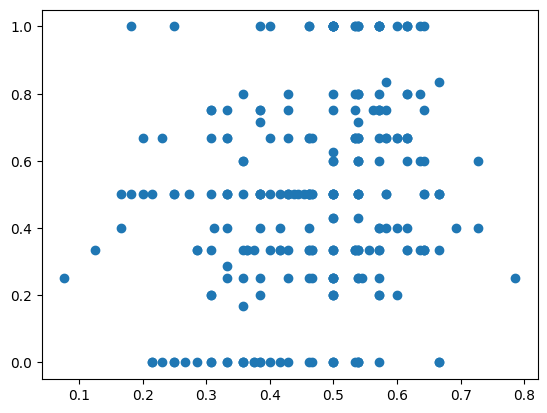

In [59]:
plt.scatter(X[:, 1], X[:, 2])
np.corrcoef(X)[2, 1]

In [6]:
clf = LogisticRegression().fit(X_train, y_train)

In [7]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [8]:
coef = clf.coef_[0]
intercept = clf.intercept_
'''
y = b0 + b1x1 + b2x2 + ...
p = b0 + b1x1 + b2x2 + ...
odds = p/1-p
log odds = log(p/1-p)
log(p/1-p) = b0 + b1x1 + b2x2 + ...
log(p/1-p) = b0 + 2.22*past5 + 1.14*past10 + 0.58*past15 + 0.73*season + 3.36*season - 0.007*away
p = sigmoid(b0 + 2.22*past5 + 1.14*past10 + 0.58*past15 + 0.73*season + 3.36*season - 0.007*away)

b7*points + b8*assists + ...
H0: b7 = b8
'''
print(f'p = sigmoid({intercept} + {coef[0]}*past5 + {coef[1]}*past10 + {coef[2]}*past15 + {coef[3]}*season + {coef[4]}*vs_opp + {coef[5]}*away)')

p = sigmoid([-4.06174343] + 2.940910917776026*past5 + 0.3141791181315479*past10 + 0.6926901074208849*past15 + 0.4694275829239621*season + 4.519614693201092*vs_opp + -0.28991565825128673*away)


In [9]:
print(f'Accuracy on train set: {clf.score(X_train, y_train)}')
print(f'Accuracy on test set: {clf.score(X_test, y_test)}')

Accuracy on train set: 0.7847025495750708
Accuracy on test set: 0.807909604519774


In [10]:
print(np.argmax(clf.predict_proba(X_test[0:10, :]), axis=1))
print(y_test[0:10])

[1 1 1 1 0 1 1 0 0 0]
[0 0 1 1 0 1 0 0 0 0]


In [64]:
from joblib import dump, load
dump(clf, 'adaboostmodel.joblib')

['adaboostmodel.joblib']

In [ ]:
np.